# Movie Recommendation System
The code starts by downloading the database of movies, users as well as the ratings. We of course make sure that it wasn't downloaded before to avoid any errors.

In [16]:
import requests
import zipfile
import os
import numpy as np

# Define the dataset URL and file paths
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
dataset_path = "ml-latest-small.zip"
extract_folder = "ml-latest-small"

# Download the dataset
if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    response = requests.get(dataset_url)
    with open(dataset_path, 'wb') as f:
        
        f.write(response.content)
    print("Download complete.")

# Extract the dataset
if not os.path.exists(extract_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")


The next step would be to import pandas, we first start by reading the csv database using pandas. And I complete by reading the head to understand the database that was extracted.

In [17]:
import pandas as pd

# Load ratings and movies files
ratings_path = os.path.join(extract_folder, "ratings.csv")
movies_path = os.path.join(extract_folder, "movies.csv")

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Preview datasets
print(ratings.head())
print(movies.head())


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Just to make sure there isn't any problems in the database that was extracted, I wanted to check if there was any missing values or null values.

In [18]:
print("Missing values in ratings:", ratings.isnull().sum())
print("Missing values in movies:", movies.isnull().sum())


Missing values in ratings: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in movies: movieId    0
title      0
genres     0
dtype: int64


Now, using pandas we easily merge the two database tables relying on the movieId, making it easier to calculate in the next steps. A quicki print of the head of the database is important to understand what is happenning.

In [19]:
data = pd.merge(ratings, movies, on='movieId')
print(data.head())

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


The following code snippet performs aggregation and sorting operations on a dataset to generate movie statistics: This code helps in identifying the most rated movies and their average ratings.


In [20]:
movie_stats = data.groupby('title').agg({'rating': ['mean', 'count']}).reset_index()
movie_stats.columns = ['title', 'average_rating', 'num_ratings']
print(movie_stats.sort_values(by='num_ratings', ascending=False).head())

                                 title  average_rating  num_ratings
3158               Forrest Gump (1994)        4.164134          329
7593  Shawshank Redemption, The (1994)        4.429022          317
6865               Pulp Fiction (1994)        4.197068          307
7680  Silence of the Lambs, The (1991)        4.161290          279
5512                Matrix, The (1999)        4.192446          278



Filtering Movies:

```Python
popular_movies = movie_stats[movie_stats['num_ratings'] >= 50]
```

This line filters the movie_stats DataFrame to include only those movies that have received 50 or more ratings.

``` movie_stats['num_ratings'] >= 50 ``` creates a boolean mask where each movie is checked if it has 50 or more ratings.
```movie_stats[movie_stats['num_ratings'] >= 50]``` applies this mask to the DataFrame, returning a new DataFrame popular_movies containing only the movies that meet the criteria.

Displaying the Result:

```Python
print(popular_movies.head())
```
This line prints the first five rows of the popular_movies DataFrame to give a quick look at the filtered data.

**Why Filter by Number of Ratings?**

Filtering by the number of ratings ensures that we are considering movies that have been rated by a substantial number of users. This helps in:

- Reducing noise from movies with very few ratings, which might not be reliable.
- Focusing on movies that are more likely to be known and watched by a larger audience.

By setting a threshold (in this case, 50 ratings), we strike a balance between having enough data for analysis and not excluding too many movies.



In [21]:
popular_movies = movie_stats[movie_stats['num_ratings'] >= 50]
print(popular_movies.head())


                                 title  average_rating  num_ratings
18   10 Things I Hate About You (1999)        3.527778           54
34                 12 Angry Men (1957)        4.149123           57
74        2001: A Space Odyssey (1968)        3.894495          109
89                28 Days Later (2002)        3.974138           58
104                         300 (2007)        3.681250           80


This code transforms a DataFrame of user ratings into a matrix format suitable for further analysis or machine learning tasks.

In [22]:
user_movie_matrix = data.pivot_table(index='userId', columns='title', values='rating')
user_movie_array = np.nan_to_num(user_movie_matrix.values)  # Replace NaN with 0
print("User-Movie Matrix shape:", user_movie_array.shape)


User-Movie Matrix shape: (610, 9719)


This code snippet leverages machine learning techniques to compute movie similarities and reduce the dimensionality of the user-movie rating matrix. It first imports necessary modules from `sklearn`. The `cosine_similarity` function calculates the similarity between movies based on user ratings, resulting in a similarity matrix stored in a DataFrame. The `TruncatedSVD` class is then used to perform dimensionality reduction on the user-movie matrix, reducing it to 100 components for more efficient computation and storage. The shape of the reduced matrix is printed to verify the transformation.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

# Compute similarity between movies
movie_similarity = cosine_similarity(user_movie_array.T)
movie_similarity_df = pd.DataFrame(
    movie_similarity, 
    index=user_movie_matrix.columns, 
    columns=user_movie_matrix.columns
)
svd = TruncatedSVD(n_components=100, random_state=42)
reduced_matrix = svd.fit_transform(user_movie_array.T)
print("Reduced Matrix shape:", reduced_matrix.shape)



Reduced Matrix shape: (9719, 100)


In [26]:
def recommend_movies(movie_title, num_recommendations=5):
    if movie_title not in movie_similarity_df:
        return f"{movie_title} not found in the dataset."
    
    # Get similarity scores for the input movie
    similar_movies = movie_similarity_df[movie_title].sort_values(ascending=False)[1:num_recommendations+1]
    return similar_movies

print("Movies similar to 'Toy Story (1995)':")
print(recommend_movies("Toy Story (1995)", num_recommendations=5))


Movies similar to 'Toy Story (1995)':
title
Toy Story 2 (1999)                           0.572601
Jurassic Park (1993)                         0.565637
Independence Day (a.k.a. ID4) (1996)         0.564262
Star Wars: Episode IV - A New Hope (1977)    0.557388
Forrest Gump (1994)                          0.547096
Name: Toy Story (1995), dtype: float64


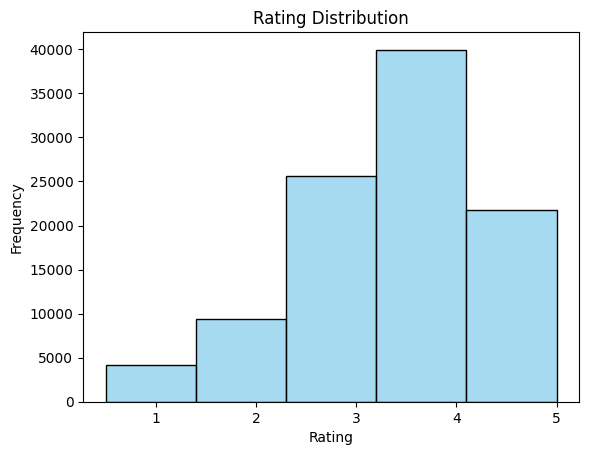

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(ratings['rating'], bins=5, kde=False, color='skyblue')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


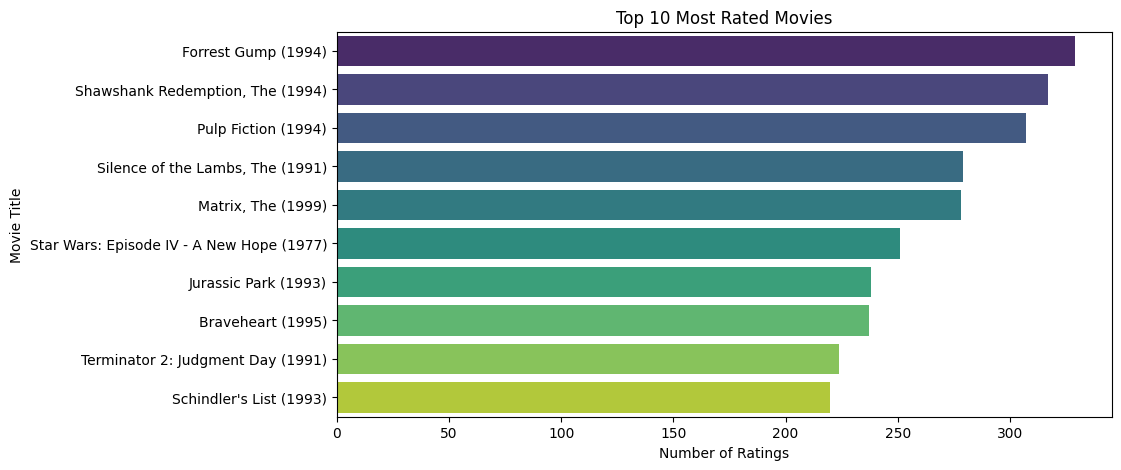

In [32]:
movie_stats = data.groupby('title').agg({'rating': ['mean', 'count']}).reset_index()
movie_stats.columns = ['title', 'average_rating', 'num_ratings']
top_rated_movies = movie_stats.sort_values(by='num_ratings', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_rated_movies, x='num_ratings', y='title', palette='viridis', hue='title')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()
